In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

In [10]:
# Number of observations
n_obs = 1000000

# Imbalance 
pct_target = 0.5

# Create imbalanced outcome
outcomes = np.random.rand(n_obs) < pct_target

In [11]:
# Function to create a linear feature that is correlated with the outcome 
def create_feature(outcomes, scale=0.1, size=10000000):
    # Create two histograms that contain possible values for this new feature
    values_0 = np.random.normal(loc=0., scale=scale, size=size)
    values_1 = np.random.normal(loc=1., scale=scale, size=size)
    
    # Sample from the histograms because on the known outcome
    result = np.zeros(outcomes.shape)
    condition = outcomes == 0
    result[condition] = np.random.choice(a=values_0, size=np.sum(condition))
    condition = outcomes == 1
    result[condition] = np.random.choice(a=values_1, size=np.sum(condition))
    
    # Return
    return result
    
# Generate 3 features
feature0 = create_feature(outcomes, scale=1.)
feature1 = create_feature(outcomes, scale=2.)
feature2 = create_feature(outcomes, scale=3.)

In [12]:
# Create cohesive dataset
df = pd.DataFrame({
    'feature0': feature0,
    'feature1': feature1,
    'feature2': feature2,
    'outcome': outcomes
})

In [13]:
columns = [column for column in df.columns if column != 'outcome']

# Look at feature performance
print('Univariate slope:')
for column in columns:
    print(column, '=', np.polyfit(df[column], df['outcome'], 1)[0])

print('\nCorrelation with outcome:')
for column in columns:
    print(column, '=', np.corrcoef(df[column], df['outcome'])[0, 1])


Univariate slope:
feature0 = 0.19983456016193127
feature1 = 0.05869204421944213
feature2 = 0.02716024122766658

Correlation with outcome:
feature0 = 0.44708976242148096
feature1 = 0.2421122459643796
feature2 = 0.165014161026893


In [14]:
# Build models
x = df[['feature0', 'feature1', 'feature2']]
y = df['outcome']

logit1 = LogisticRegression()
logit2 = LogisticRegression(class_weight='balanced')

logit1.fit(x, y)
logit2.fit(x, y)

y_pred1 = logit1.predict_proba(x)[:, 1]
y_pred2 = logit2.predict_proba(x)[:, 1]

Imbalanced AUC= 0.7954662601687744
Implicitly Balanced AUC= 0.7954662605767744


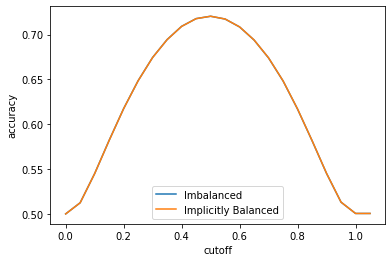

In [15]:
# AUC
print('Imbalanced AUC=', roc_auc_score(y, y_pred1))
print('Implicitly Balanced AUC=', roc_auc_score(y, y_pred2))

# Compute accuracy vs threshold
thresholds = np.arange(0, 1.1, 0.05)
accuracies1 = []
accuracies2 = []
for threshold in thresholds:
    accuracies1.append(accuracy_score(y, y_pred1 >= threshold))
    accuracies2.append(accuracy_score(y, y_pred2 >= threshold))
    
# Plot
plt.figure()
plt.plot(thresholds, accuracies1, label='Imbalanced')
plt.plot(thresholds, accuracies2, label='Implicitly Balanced')
plt.xlabel('cutoff')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [16]:
# Finally look at the coefficients
result = pd.DataFrame({
    'feature': x.columns,
    'coef1': logit1.coef_[0],
    'coef2': logit2.coef_[0]
})

result.loc[len(result)] = [
    'intecept', 
    logit1.intercept_[0],
    logit2.intercept_[0]
]

print(result.set_index('feature'))


             coef1     coef2
feature                     
feature0  0.999074  0.999075
feature1  0.249887  0.249887
feature2  0.112182  0.112182
intecept -0.682573 -0.681554
